In [0]:
import tensorflow as tf

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [0]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2020-06-10 13:59:17--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 172.67.213.166, 104.31.81.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.05s   

2020-06-10 13:59:18 (9.38 MB/s) - ‘spam.csv’ saved [503663/503663]



In [0]:
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")

In [0]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [0]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
df.columns=["labels", "data"]

In [0]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
df["labels"] = df["labels"].map({"ham": 0, "spam": 1})

In [0]:
# split up the data
train_emails, test_emails, train_label, test_label = train_test_split(df['data'], df["labels"].values, test_size=0.33)

In [0]:
# Convert sentences to sequences
max_vocab_size = 20000
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(train_emails)
sequences_train = tokenizer.texts_to_sequences(train_emails)
sequences_test = tokenizer.texts_to_sequences(test_emails)

In [0]:
# get word to integer mapping
word2idx = tokenizer.word_index
v = len(word2idx)
print("Found %s unique tokens." % v)

Found 7254 unique tokens.


In [0]:
# pad sequences to get a N x T matrix
data_train = pad_sequences(sequences_train)
print("Shape of data train tensor:", data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [0]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [0]:
# create the model using functional TensorFlow

# Choose embedding dimensionality
D = 20

# Choose hidden state dimentionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0. (since 0 is reserved for padding)
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.


i = Input(shape=(T,))
x = Embedding(v + 1, D)(i)

# use return_sequences=True and GlobalMaxPooling1D as we want all of the hidden units to 
# get all the yhats. 

x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(i, x)

In [0]:
# compile and fit
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

print("Training model...")

r = model.fit(
    data_train,
    train_label,
    epochs=10,
    validation_data=(data_test, test_label)
)

Training model...
Epoch 1/10
117/117 [==============================] - 8s 70ms/step - loss: 0.4772 - accuracy: 0.8578 - val_loss: 0.4034 - val_accuracy: 0.8592
Epoch 2/10
117/117 [==============================] - 8s 70ms/step - loss: 0.3642 - accuracy: 0.8693 - val_loss: 0.3495 - val_accuracy: 0.8592
Epoch 3/10
117/117 [==============================] - 8s 69ms/step - loss: 0.3090 - accuracy: 0.8693 - val_loss: 0.3047 - val_accuracy: 0.8592
Epoch 4/10
117/117 [==============================] - 8s 68ms/step - loss: 0.2617 - accuracy: 0.8693 - val_loss: 0.2597 - val_accuracy: 0.8592
Epoch 5/10
117/117 [==============================] - 8s 68ms/step - loss: 0.2102 - accuracy: 0.8693 - val_loss: 0.2129 - val_accuracy: 0.8592
Epoch 6/10
117/117 [==============================] - 8s 68ms/step - loss: 0.1624 - accuracy: 0.9282 - val_loss: 0.1600 - val_accuracy: 0.9647
Epoch 7/10
117/117 [==============================] - 8s 71ms/step - loss: 0.1042 - accuracy: 0.9890 - val_loss: 0.1148 - va

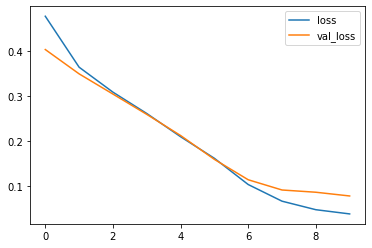

In [0]:
# plot loss per iteration
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

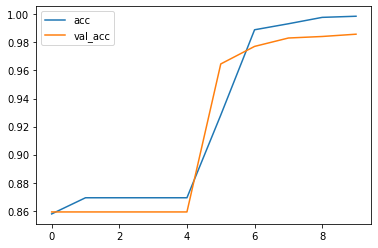

In [0]:
# plot accuracy per iteration
plt.plot(r.history["accuracy"], label="acc")
plt.plot(r.history["val_accuracy"], label="val_acc")
plt.legend()

In [0]:
print(model.evaluate(data_test, test_label))

58/58 [==============================] - 1s 11ms/step - loss: 0.0789 - accuracy: 0.9859
[0.07888267934322357, 0.9858618974685669]


In [0]:
# Convert the model to TFLite format

# Create a converter object
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# convert the model
tflite_model = converter.convert()

# save to file
with open("converted_model.tflite", "wb") as f:
  f.write(tflite_model)

In [0]:
# check if it exists
!ls

converted_model.tflite	sample_data  server.log  spam.csv
